<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/MGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup


In [ ]:
# Importando as Bibliotecas

import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

In [ ]:
# Clonando repo do Git

!git clone https://github.com/andryll/MGR-IC.git

Cloning into 'MGR-IC'...
remote: Enumerating objects: 1080, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 1080 (delta 27), reused 8 (delta 0), pack-reused 999
Receiving objects: 100% (1080/1080), 1.13 GiB | 20.37 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (1004/1004), done.


###Leitura das Músicas

In [ ]:
def splitSongs (songList, duration, sr=44100):

  # Converta o tamanho da janela de segundos para amostras
  window_size_samples = int(duration * sr)

  # Inicialize uma lista para armazenar os segmentos
  segmentedList = []

  # Pega cada música da lista
  for y in songList:

    # Calcule o número total de segmentos
    num_segments = len(y[0]) // window_size_samples

    # Divida o áudio em segmentos de 5 segundos e adcione-os na lista
    for i in range(num_segments):
        start = i * window_size_samples
        end = (i + 1) * window_size_samples
        segment = (y[0][start:end], y[1], y[2])
        segmentedList.append(segment)

  # Retorna a nova lista
  return segmentedList

In [ ]:
def readSongs (genre, numSongs, sr=44100, duration = 30):

  # Declarando listas iniciais
  songs = []
  genrelist = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
                'metal', 'pop', 'reggae', 'rock']

  # Se a escolha de gênero não for 'all', substitui a lista pelo gênero escolhido
  if genre != 'all':
    genrelist = [genre]

  #Percorre todos os gêneros da lista
  for g in genrelist:
    #Pega o caminho para a pasta do gênero escolhido
    dir_path = os.path.join('/content/MGR-IC/songs/', g)
    #Lista os arquivos da pasta e os embaralha
    files = os.listdir(dir_path)
    files.sort

    # Até o número de musicas desejado ser alcançado, lê os arquivos de áudio com o librosa
    for i in range(numSongs):
      songs.append(librosa.load(os.path.join(dir_path, files[i]), sr=sr, mono = True, duration = 30))
      # Adciona o gênero como uma variável da tupla
      songs[-1] = songs[-1] + (g,)

  max_len = max(len(song[0]) for song in songs)

  # Garante que todas as músicas terão o mesmo tamanho da maior
  resized_songs = []
  for song in songs:
      # Verifica se a música precisa ser redimensionada
      if len(song[0]) < max_len:
          # Adiciona zeros à direita para igualar o tamanho
          padded_audio = librosa.util.pad_center(data = song[0], size = max_len, axis = 0)
          resized_songs.append((padded_audio, song[1], song[2]))
      else:
          resized_songs.append(song)

  new_songs = splitSongs (resized_songs, sr=sr, duration = duration)

  return new_songs

###Extração das Features

In [ ]:
# Reduz a dimensionalidade dos dados
def reduceDimension(dataframe, rate=0.99):
  X = dataframe.drop(columns=['Classe']).values.tolist()
  Y = dataframe['Classe'].values.tolist()

  scaler = preprocessing.StandardScaler()
  X_scaled = scaler.fit_transform(X)

  pca = PCA(n_components= rate)
  X_pca = pca.fit_transform(X_scaled)

  df = pd.concat([pd.DataFrame(X_pca), pd.DataFrame({'Classe': Y})], axis=1)

  return df

In [ ]:
def featureExtraction (songs, feature, sr=44100, frame=512):

  featurelist = []

  for i in songs:

    match feature:
      case 'zcr':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(zcr[0]).transpose()

      case 'rms':
        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(rms[0]).transpose()

      case 'mfcc':
        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        aux = pd.DataFrame(mfcc).transpose()

      case 'centroid':
        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(sctoid[0]).transpose()


      case 'rolloff':
        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        aux = pd.concat([pd.DataFrame(srloff1), pd.DataFrame(srloff99)], axis=1)

      case 'all':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        zcrdf = pd.DataFrame(zcr[0]).transpose()

        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        rmsdf = pd.DataFrame(rms[0]).transpose()

        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        mfccdf = pd.DataFrame(mfcc).transpose()

        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        sctoiddf = pd.DataFrame(sctoid[0]).transpose()

        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        srloff99df = pd.DataFrame(srloff99)
        srloff1df = pd.DataFrame(srloff1)

        aux = pd.concat([zcrdf, rmsdf, mfccdf, sctoiddf, srloff1df, srloff99df], axis=1)

      case _:
        print('Feature Inválida')

    aux['Classe'] = i[2]
    featurelist.append(aux)

  df = pd.concat(featurelist, axis=0)
  df = reduceDimension(df, 0.99)

  return df

### Algoritmos de ML


In [ ]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    target = 'Classe'
    X_columns = dataframe.columns[dataframe.columns != target]
    X = dataframe[X_columns]
    Y = dataframe[target]

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [ ]:
def elbowKNN(dflist, n_neigh, seed):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        neigh.fit(X_train[i], Y_train[i])
        Y_predict = neigh.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [ ]:
def elbowTree(dflist, seed):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        clf.fit(X_train[i], Y_train[i])
        Y_predict = clf.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [ ]:
def elbowRF(dflist, seed):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        rf.fit(X_train[i], Y_train[i])
        Y_predict = rf.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

### Testes

In [ ]:
# Lê as músicas
songs = readSongs ('all', 50, 44100, 10)

In [ ]:
# Extrai as features para os frame lenghts desejados
frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]

dflist = []
for f in frame_lenghts:
  dflist.append(featureExtraction(songs, 'all', 44100, frame=f))

In [ ]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed))

  dtscores.append(elbowTree(dflist, seed = seed))
  rfscores.append(elbowRF(dflist, seed = seed))

### Plot dos Diagramas

In [ ]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

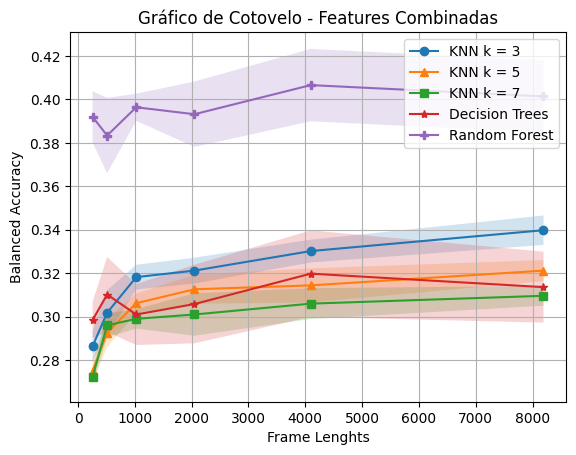

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

labels = ['KNN k = 3', 'KNN k = 5', 'KNN k = 7', 'Decision Trees', 'Random Forest']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Features Combinadas | Splits de 10s')

# Nome do arquivo pra salvar
plt.savefig('10s.pdf')
plt.show()

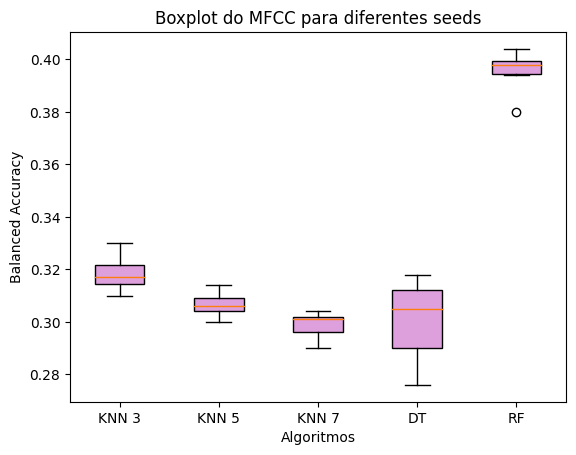

In [ ]:
#Plotando o boxplot

boxplot = []
boxplot.append((np.array(knnscores3).flatten()).tolist())
boxplot.append((np.array(knnscores5).flatten()).tolist())
boxplot.append((np.array(knnscores7).flatten()).tolist())
boxplot.append((np.array(dtscores).flatten()).tolist())
boxplot.append((np.array(rfscores).flatten()).tolist())

algs = ['KNN 3', 'KNN 5', 'KNN 7', 'DT', 'RF']
cores= ['red','green','purple','orange','blue']
box = plt.boxplot(boxplot, labels=algs, patch_artist=True,
            boxprops=dict(facecolor='plum', color='black'))

plt.title('Boxplot do MFCC para diferentes seeds')
plt.xlabel('Algoritmos')
plt.ylabel('Balanced Accuracy')

plt.savefig('mfcc.pdf')
plt.show()

In [ ]:
# Plot alternativo com gráfico de barras

# algs = ['KNN 3', 'KNN 5', 'KNN 7', 'DT', 'RF']

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i+0.02, y[i] + 0.005, round(y[i], 3))

# plt.bar(algs, sm, color=['plum','lightblue','palegreen','khaki','lightcoral'])
# plt.errorbar(algs,sm,sd,fmt='.',color='Black', elinewidth=2,capthick=8,errorevery=1, alpha=0.8, ms=2, capsize = 1.5)
# plt.ylabel('Balanced Accuracy')
# plt.xlabel('Algoritmos')

# addlabels(algs, sm)

# plt.title('MFCC')
# plt.savefig('mfcc.pdf')
# plt.show()

###Temporário

In [ ]:

# Carregue o áudio
audio_path = '/content/MGR-IC/songs/blues/blues.00001.wav'
y, sr = librosa.load(audio_path, sr=44100, duration = 30)

# Defina o tamanho da janela em segundos
window_size = 10

# Converta o tamanho da janela de segundos para amostras
window_size_samples = int(window_size * sr)

# Calcule o número total de segmentos
num_segments = len(y) // window_size_samples

# Inicialize uma lista para armazenar os segmentos
segments = []

# Divida o áudio em segmentos de 5 segundos
for i in range(num_segments):
    start = i * window_size_samples
    end = (i + 1) * window_size_samples
    segment = y[start:end]
    segments.append(segment)

# Se o último segmento for menor que 5 segundos, adicione-o também
if len(y) % window_size_samples != 0:
    last_segment = y[num_segments * window_size_samples:]
    segments.append(last_segment)

# Agora a lista "segments" contém todos os segmentos de 5 segundos do áudio
# Cada segmento é uma matriz numpy contendo as amostras de áudio

# Exemplo de como acessar o primeiro segmento:
print("Número de segmentos:", len(segments))
print("Tamanho do primeiro segmento:", len(segments[0]))

Número de segmentos: 3
Tamanho do primeiro segmento: 441000


In [ ]:
# Lê as músicas
songs = readSongs ('all', 2, 44100, 10)

In [ ]:
ipd.Audio(songs[54][0], rate=songs[54][1])

In [ ]:
for song in songs:
  print(song[2])

blues
blues
blues
blues
blues
blues
classical
classical
classical
classical
classical
classical
country
country
country
country
country
country
disco
disco
disco
disco
disco
disco
hiphop
hiphop
hiphop
hiphop
hiphop
hiphop
jazz
jazz
jazz
jazz
jazz
jazz
metal
metal
metal
metal
metal
metal
pop
pop
pop
pop
pop
pop
reggae
reggae
reggae
reggae
reggae
reggae
rock
rock
rock
rock
rock
rock
